In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
train = pd.read_csv('train.csv')
train

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0
...,...,...,...
4999995,499.9996,2.9194,7
4999996,499.9997,2.6980,7
4999997,499.9998,4.5164,8
4999998,499.9999,5.6397,9


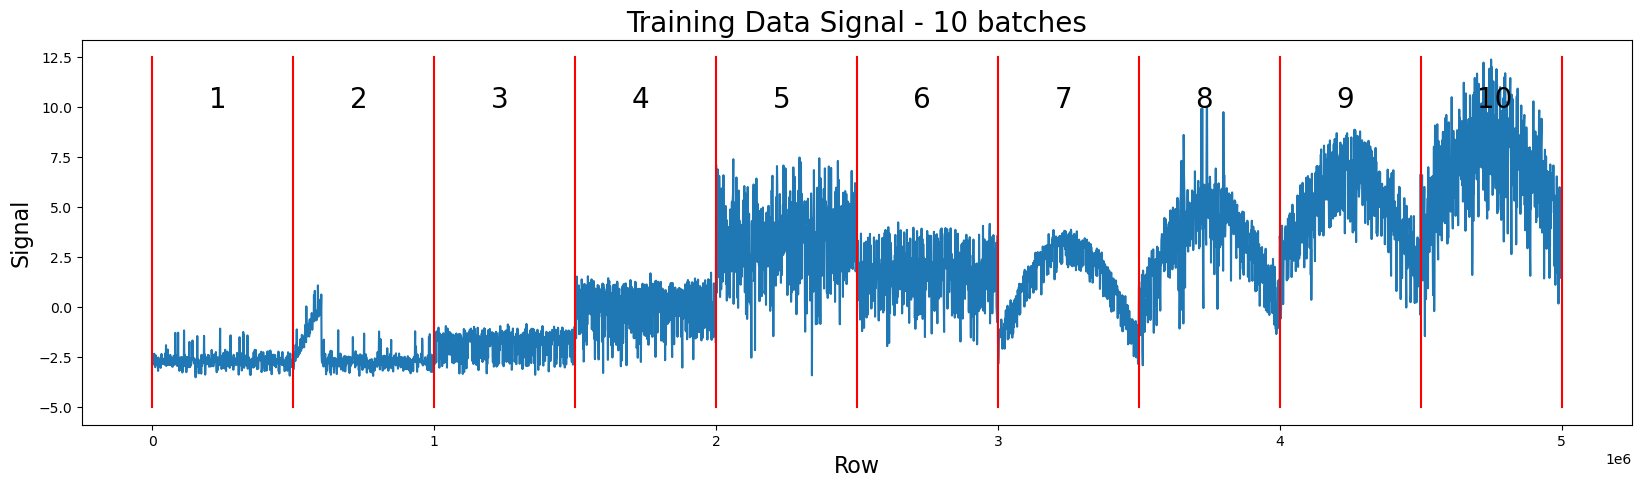

In [102]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

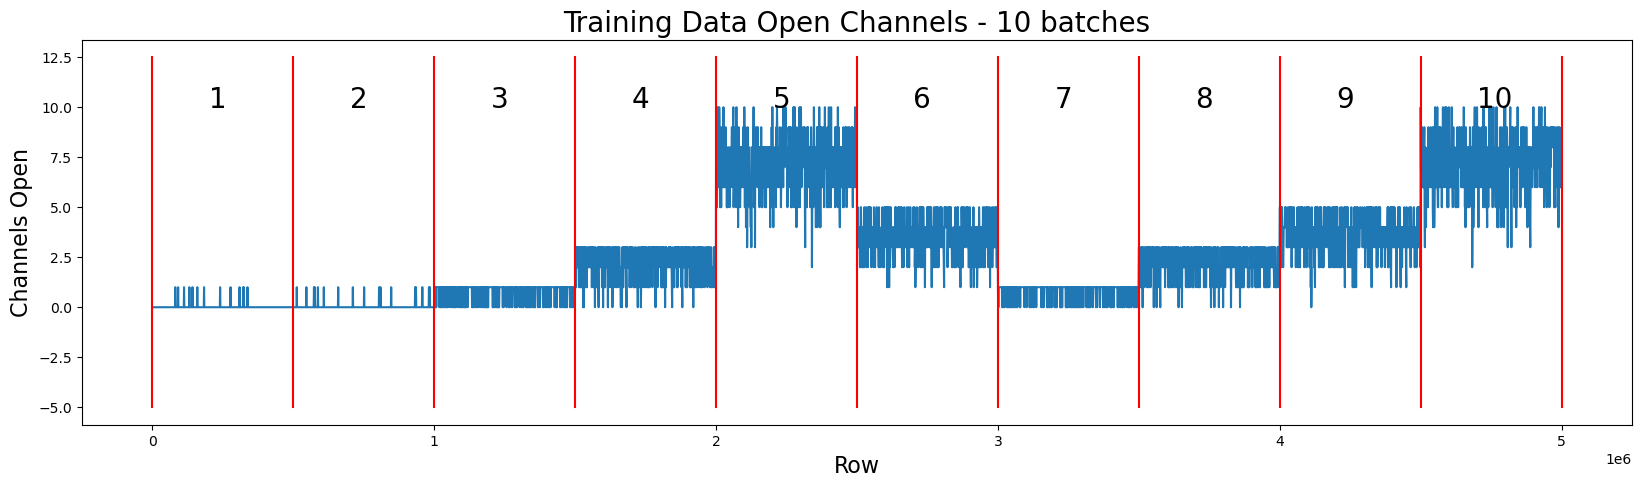

In [103]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

In [104]:
Batch1 = train[:500000]
Batch5 = train[2000000:2500000]

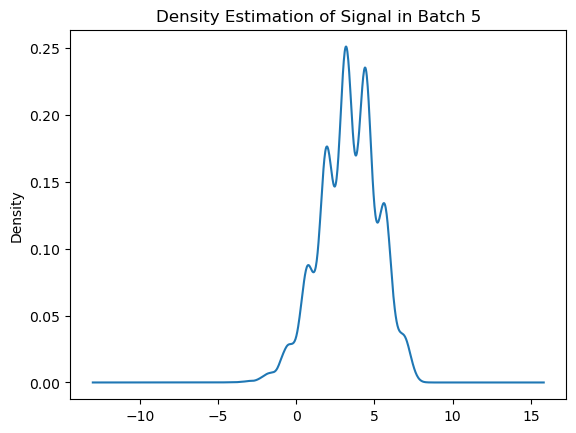

In [105]:
pd.Series(Batch5['signal']).plot(kind='density', title='Density Estimation of Signal in Batch 5')
plt.show()

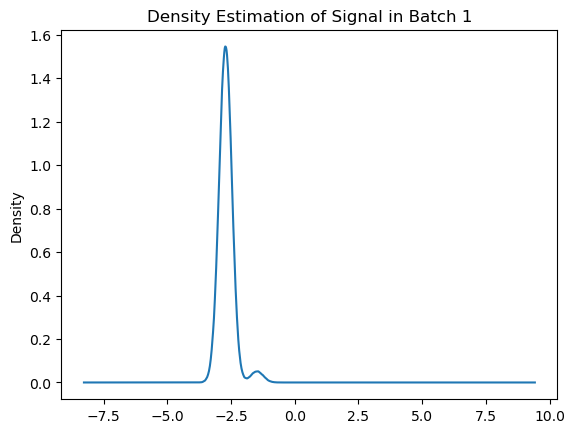

In [106]:
pd.Series(Batch1['signal']).plot(kind='density', title='Density Estimation of Signal in Batch 1')
plt.show()

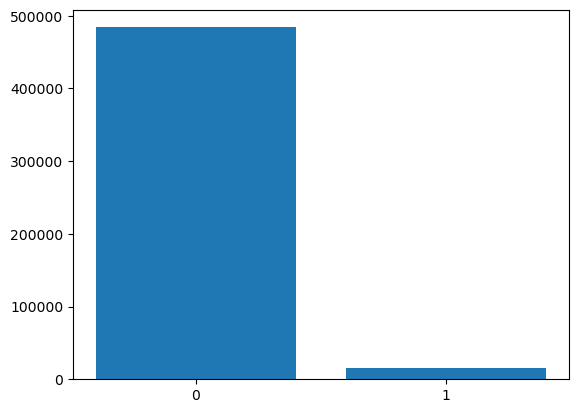

In [107]:
open_channel_count, freq = np.unique(Batch1['open_channels'], return_counts=True)
plt.bar(open_channel_count, freq)
plt.xticks([0,1])
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10] [     2     57    526   3426  14625  45145  92779 132319 123243  69650
  18228]


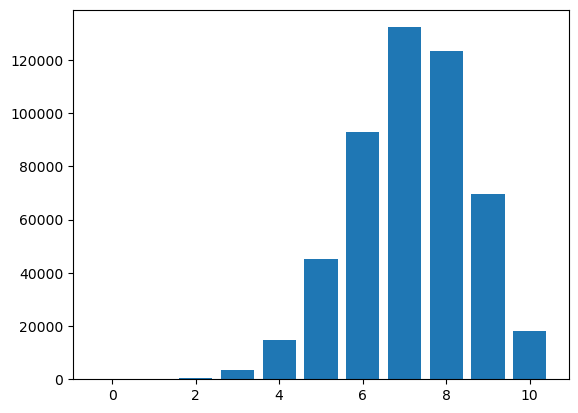

In [108]:
open_channel_count, freq = np.unique(Batch5['open_channels'], return_counts=True)
print(open_channel_count, freq)
plt.bar(open_channel_count, freq)
plt.show()

In [109]:
from hmmlearn import hmm
import deepchem as dc

In [110]:
df = pd.concat(objs=[Batch1, Batch5])

<Axes: title={'center': 'Density Estimation of Signal in df'}, ylabel='Density'>

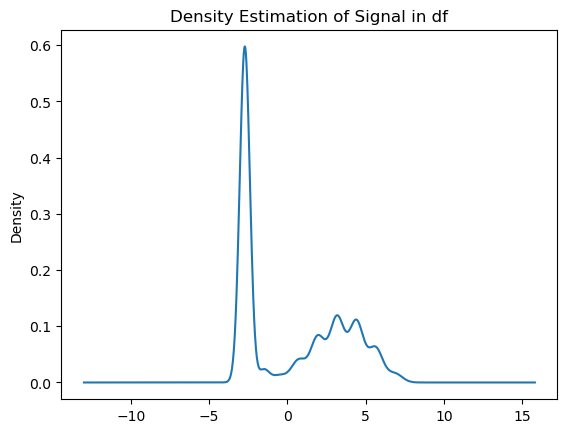

In [111]:
pd.Series(df['signal']).plot(kind='density', title='Density Estimation of Signal in df')

[ 0  1  2  3  4  5  6  7  8  9 10] [484136  15923    526   3426  14625  45145  92779 132319 123243  69650
  18228]


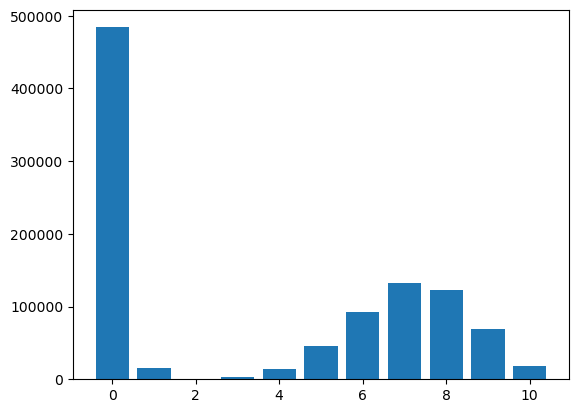

In [112]:
open_channel_count, freq = np.unique(df['open_channels'], return_counts=True)
print(open_channel_count, freq)
plt.bar(open_channel_count, freq)
plt.show()

In [113]:
df_tensor = np.array([np.array(df['signal'][0:500000]).reshape(-1,1),np.array(df['signal'][500000:1000000]).reshape(-1,1)])
# this is done to convert data into 3d matrix such that train_batch[i][j][k] is i-th sequence, j-th timestep, k-th feature
df_tensor


array([[[-2.76  ],
        [-2.8557],
        [-2.4074],
        ...,
        [-2.9536],
        [-2.7725],
        [-2.8171]],

       [[ 7.1191],
        [ 6.7712],
        [ 6.9278],
        ...,
        [ 1.8639],
        [ 3.6897],
        [ 2.851 ]]], shape=(2, 500000, 1))

In [114]:
model = hmm.GaussianHMM(n_components=11, n_iter=100)
dc_model = dc.models.hmmlearn_models.HmmlearnModel(model)
dataset = dc.data.NumpyDataset(df_tensor)

In [115]:
dc_model.fit(dataset)

[500000 500000]


In [116]:
res = dc_model.predict(dataset)

In [140]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# These handle the "State Splitting" and "Label Switching" automatically
ari = adjusted_rand_score(df['open_channels'], res)
nmi = normalized_mutual_info_score(df['open_channels'], res)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info Score: {nmi:.4f}")

Adjusted Rand Index: 0.8414
Normalized Mutual Info Score: 0.6701


In [118]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['open_channels'], res)
cm

array([[     0,      6,      0,      0,      0, 478185,      0,      0,
          5945,      0,      0],
       [     0,     43,      0,      0,      0,     17,      0,      0,
         15863,      0,      0],
       [     0,    434,      0,      0,      0,      0,      0,      0,
            92,      0,      0],
       [     0,   3229,      0,      0,      0,      0,      3,      0,
           166,     28,      0],
       [     0,  10734,     26,      0,      0,      0,    804,      0,
            65,   2971,     25],
       [     0,   8982,   2316,      0,      0,      0,   6948,      0,
             3,  24317,   2579],
       [    40,   1601,  39915,      0,      7,      0,   5325,    146,
             0,  38898,   6847],
       [  5463,    123, 105834,     21,    595,      0,    128,   7801,
             0,  11871,    483],
       [ 39148,      4,  41078,   4803,   6981,      0,      0,  30349,
             0,    880,      0],
       [ 16148,      0,   2057,  35110,  11889,      0,

In [133]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(-cm)
mapping = dict(zip(col_ind, row_ind))

In [134]:
res_aligned = np.array([mapping[s] for s in res])

In [135]:
model.means_

array([[ 4.60346407],
       [-0.09168275],
       [ 3.15115522],
       [ 6.01839127],
       [ 4.80929468],
       [-2.72114243],
       [ 1.26722853],
       [ 4.39290312],
       [-1.81032694],
       [ 1.6971276 ],
       [ 1.78190217]])